In [1]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, DMatrix
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import random
from conditionalconformal import CondConf
from matplotlib.patches import Patch
from scipy.spatial import ConvexHull

''' import functions and values from other modules '''
from conformal_auxiliary import phi_fn
from coverage import conformal_predict_z_0
from Myerson_auction import myerson_reserve
from simu_exp import conformal_predict

- Realization of Figure 1(a) in Appendix D.1

In [2]:
'''
Calculate the coverage probability of the conformal prediction interval for the values in a new auction, 
evaluating different types of items
'''

np.random.seed(1)
'''First type of item'''
IR_7, d_7 = conformal_predict_z_0(alpha=0.1, m=50, z_0=7)

'''Second type of item'''
IR_3, d_3 = conformal_predict_z_0(alpha=0.1, m=50, z_0=3)

'''Third type of item'''
IR_5, d_5 = conformal_predict_z_0(alpha=0.1, m=50, z_0=5)

IR = [IR_3, IR_5, IR_7]  

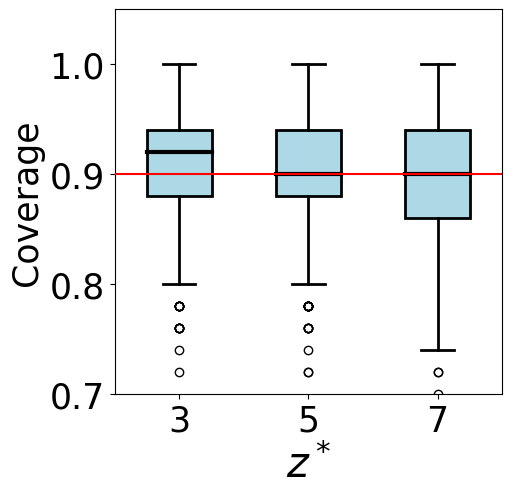

In [3]:
'''
Draw the boxplots of the coverage probability (Figure 1(a) in Appendix D.1)
'''

fig = plt.figure(figsize=(5, 5))

alpha = 0.1
plt.boxplot(IR, patch_artist=True, 
            medianprops=dict(color="black", linewidth=3),  
            boxprops=dict(facecolor='lightblue', linewidth=2),  
            whiskerprops=dict(linewidth=2),  
            capprops=dict(linewidth=2),widths=0.5)  

plt.axhline(y=1-alpha, color='red', linestyle='-', label='', linewidth=1.5,zorder=3)
plt.ylim(0.7, 1.05)
plt.xlabel('$z^*$', fontsize=30)
plt.ylabel('Coverage', fontsize=25)
plt.locator_params(axis='y', nbins=5)  
plt.yticks( fontsize=25)
plt.xticks([1, 2, 3], [3, 5, 7], fontsize=25)  
plt.show()

- Realization of Figure 1(c) in Appendix D.1

In [4]:
'''
Calculate the revenue from different mechanisms with varying numbers of data points in 1000 experiments.
'''

np.random.seed(1)

# Set different values for N
N_values = [200, 600, 1000, 1400, 1800]
z_values = [3, 5, 7]
num_runs = 1000
m = 50

# Initialize a more detailed results dictionary for each z_0 value
results = {z: [] for z in z_values}

# Simulation for each z value
for z_0 in z_values:
    np.random.seed(1)
    # For each value of N, run the function 1000 times 
    for N in N_values:
        payments, myerson_values, myerson_reserve_prices, sb_values, max_welfares = [], [], [], [], []
        for _ in range(num_runs):
            payment, myerson_value, myerson_reserve_price, sb_value, max_welfare = conformal_predict(m, z_0, N)
            payments.append(payment)
            myerson_values.append(myerson_value)
            myerson_reserve_prices.append(myerson_reserve_price)
            sb_values.append(sb_value)
            max_welfares.append(max_welfare)
        results[z_0].append({
            "N": N,
            "payments": payments,  # Revenue of COAD
            "sb_values": sb_values,  # Revenue of second-price auction
            "max_welfares": max_welfares,  # Maximum social welfare
            "myerson_values":  myerson_values,   # Revenue of empirical Myerson auction
            "myerson_reserve_prices": myerson_reserve_prices
        })


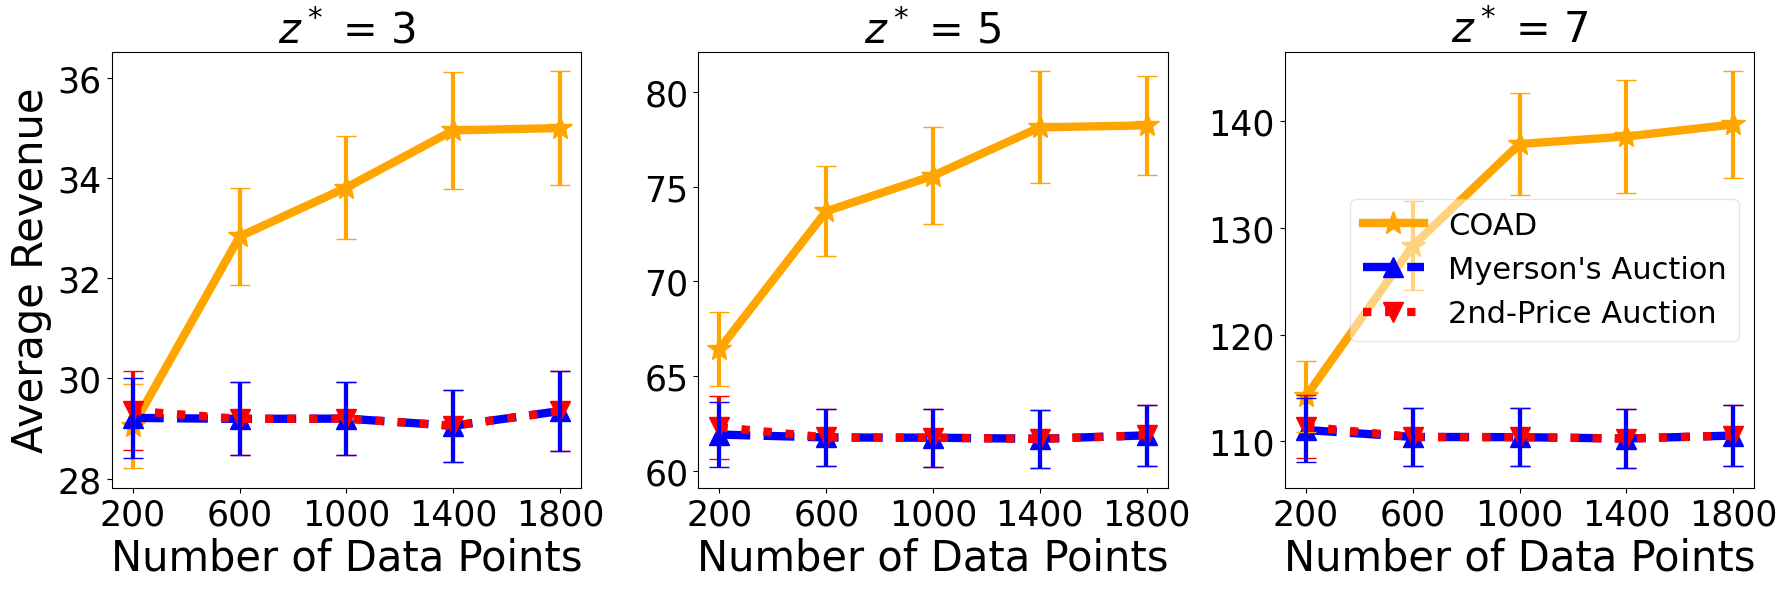

In [5]:
''' Draw the Figure 1(c) in Appendix D.1 '''

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  

for i, z_0 in enumerate(z_values):
    payments_means = []
    payments_ses = []
    sb_values_means = []
    sb_values_ses = []
    max_welfares_means = []
    max_welfares_ses = []
    myerson_values_means = []
    myerson_values_ses = []

    # Calculate the average revenue of different mechanisms under different number of data points, and add the error bars
    for entry in results[z_0]:
        payments_means.append(np.mean(entry['payments']))
        payments_ses.append(1.96 * np.std(entry['payments']) / np.sqrt(len(entry['payments'])))
        sb_values_means.append(np.mean(entry['sb_values']))
        sb_values_ses.append(1.96 * np.std(entry['sb_values']) / np.sqrt(len(entry['sb_values'])))
        max_welfares_means.append(np.mean(entry['max_welfares']))
        max_welfares_ses.append(1.96 * np.std(entry['max_welfares']) / np.sqrt(len(entry['max_welfares'])))
        myerson_values_means.append(np.mean(entry['myerson_values']))
        myerson_values_ses.append(1.96 * np.std(entry['myerson_values']) / np.sqrt(len(entry['myerson_values'])))

   
    axs[i].plot(N_values, payments_means, label="COAD", color='orange', linestyle='-', marker='*', linewidth=6, markersize=18)
    axs[i].plot(N_values, myerson_values_means, label="Myerson's Auction", color='blue', linestyle='--', marker='^', linewidth=6, markersize=14)
    axs[i].plot(N_values, sb_values_means, label="2nd-Price Auction", color='red', linestyle=':', marker='v', linewidth=6, markersize=14)
    axs[i].errorbar(N_values, payments_means, yerr=payments_ses, fmt='none', ecolor='orange', capsize=7, elinewidth=3)
    axs[i].errorbar(N_values, sb_values_means, yerr=sb_values_ses, fmt='none', ecolor='red', capsize=7, elinewidth=3)
    axs[i].errorbar(N_values, myerson_values_means, yerr=myerson_values_ses, fmt='none', ecolor='blue', capsize=7, elinewidth=3)

    axs[i].set_xlabel("Number of Data Points", fontsize=30)
    axs[i].set_ylabel("Average Revenue" if i == 0 else "", fontsize=30)  
    axs[i].set_title(f"$z^*$ = {z_0}", fontsize=30)
    axs[i].tick_params(axis='both', labelsize=25)
    axs[i].set_xticks([200, 600, 1000, 1400, 1800])  
    if i == 2:
        axs[i].legend(fontsize=22, facecolor='white', framealpha=0.5)

plt.tight_layout()
plt.show()

- Realization of Figure 1(b) in Appendix D.1

In [6]:
''' 
For each value of m, run the experiments 1000 times and save the revenue of different mechanims 
'''

np.random.seed(1)

m_values = list(range(50, 401, 50))
N = 5000
num_runs = 1000
z_0_values = [3, 5, 7]  # Different z values for each plot
# Initialize a more detailed results dictionary for each z_0 value
results_m = {z: [] for z in z_values}

for i, z_0 in enumerate(z_0_values):
    np.random.seed(0)
    for m in m_values:
        payments, myerson_values, myerson_reserve_prices, sb_values, max_welfares = [], [], [], [], []
        for _ in range(num_runs):
            payment, myerson_value, myerson_reserve_price, sb_value, max_welfare = conformal_predict(m, z_0, N)
            payments.append(payment)
            myerson_values.append(myerson_value)
            myerson_reserve_prices.append(myerson_reserve_price)
            sb_values.append(sb_value)
            max_welfares.append(max_welfare)
        results_m[z_0].append({
            "m": m,
            "payments": payments,   # Revenue of COAD
            "sb_values": sb_values,   # Revenue of second-price auction
            "max_welfares": max_welfares,   # Maximum social welfare
            "myerson_values":  myerson_values,    # Revenue of empirical Myerson auction
            "myerson_reserve_prices": myerson_reserve_prices
        })

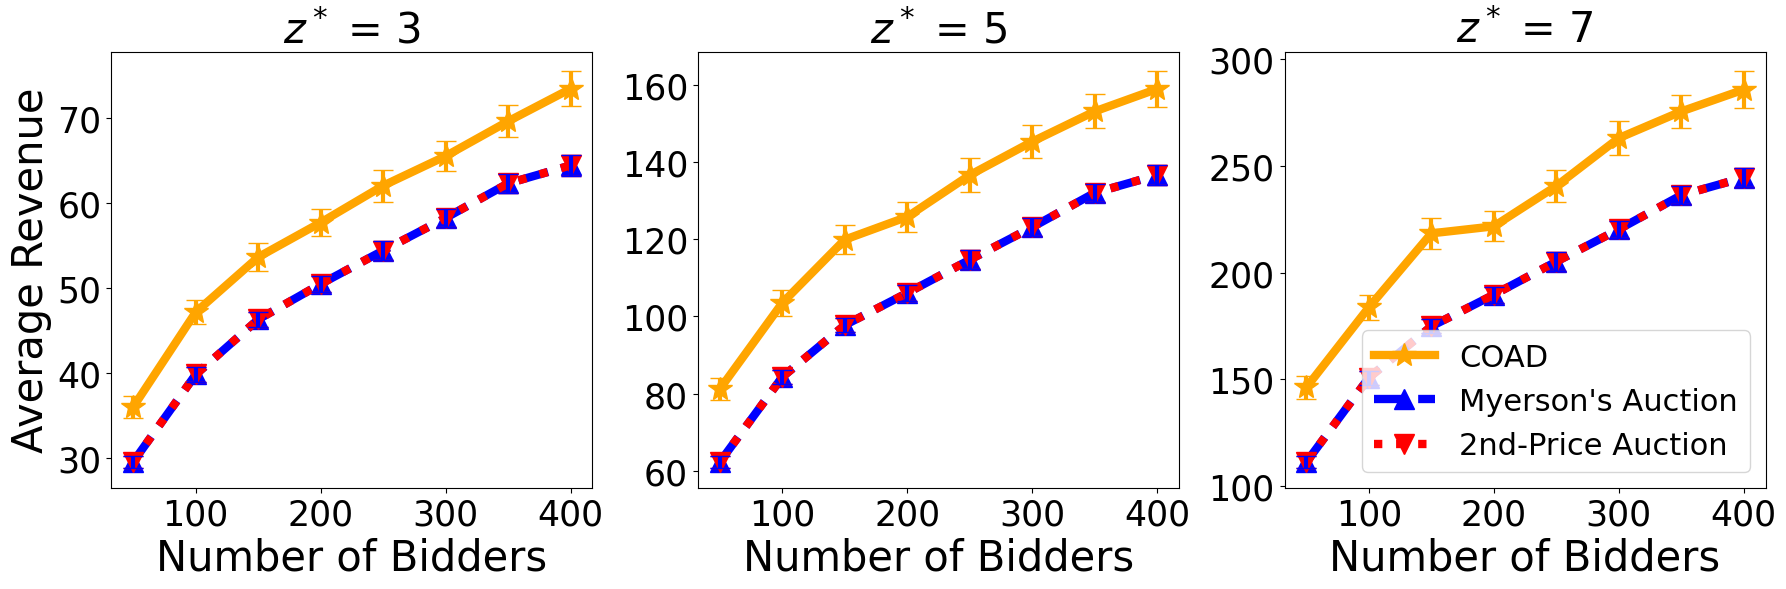

In [7]:
''' 
Draw the Figure 1(b) in Appendix D.1
'''

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, z_0 in enumerate(z_0_values):
    m_values = [entry['m'] for entry in results_m[z_0]]
    # Calculate the average revenue of different mechanisms under different number of bidders, and add the error bars
    payments_means = [np.mean(entry['payments']) for entry in results_m[z_0]]
    payments_ses = [1.96*np.std(entry['payments']) / np.sqrt(len(entry['payments'])) for entry in results_m[z_0]]
    sb_values_means = [np.mean(entry['sb_values']) for entry in results_m[z_0]]
    sb_values_ses = [1.96*np.std(entry['sb_values']) / np.sqrt(len(entry['sb_values'])) for entry in results_m[z_0]]
    max_welfares_means = [np.mean(entry['max_welfares']) for entry in results_m[z_0]]
    max_welfares_ses = [1.96*np.std(entry['max_welfares']) / np.sqrt(len(entry['max_welfares'])) for entry in results_m[z_0]]
    myerson_values_means = [np.mean(entry['myerson_values']) for entry in results_m[z_0]]
    myerson_values_ses = [1.96 * np.std(entry['myerson_values']) / np.sqrt(len(entry['myerson_values'])) for entry in results_m[z_0]]
    
    axs[i].plot(m_values, payments_means, label="COAD", color='orange', linestyle='-', marker='*', linewidth=6, markersize=18)
    axs[i].plot(m_values, myerson_values_means, label="Myerson's Auction", color='blue', linestyle='--', marker='^', linewidth=6, markersize=14)
    axs[i].plot(m_values, sb_values_means, label="2nd-Price Auction", color='red', linestyle=':', marker='v', linewidth=6, markersize=14)
    axs[i].errorbar(m_values, payments_means, yerr=payments_ses, fmt='none', ecolor='orange', capsize=7, elinewidth=3)
    axs[i].errorbar(m_values, sb_values_means, yerr=sb_values_ses, fmt='none', ecolor='red', capsize=7, elinewidth=3)
    axs[i].errorbar(m_values, myerson_values_means, yerr=myerson_values_ses, fmt='none', ecolor='blue', capsize=7, elinewidth=3)
        
    axs[i].set_xlabel("Number of Bidders", fontsize=30)
    axs[i].tick_params(axis='both', which='major', labelsize=25)
    axs[i].locator_params(axis='y', nbins=7)
    axs[i].set_title(f"$z^*$ = {z_0}", fontsize=30)
    if i == 2:
        axs[i].legend(fontsize=22, loc='lower right')
axs[0].set_ylabel("Average Revenue", fontsize=30)
plt.tight_layout()
plt.show()